# *santoshhulbutti@gmail.com | FlipRobo | Project #05

# Malignant Comments Classification

## Importing necessary libraries

In [62]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_style('darkgrid')

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.model_selection import train_test_split,cross_val_score, GridSearchCV 

from sklearn.metrics import confusion_matrix,multilabel_confusion_matrix,classification_report,accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_score,f1_score
from sklearn.metrics import hamming_loss, log_loss

pd.set_option('max_columns', None)

import warnings
warnings.filterwarnings('ignore')

### Dataset loading

In [63]:
train0 = pd.read_csv('train.csv')
test0 = pd.read_csv('test.csv')

In [64]:
train0.shape

(159571, 8)

In [65]:
test0.shape

(153164, 2)

In [66]:
train0

,id,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0


In [67]:
test0

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
...,...,...
153159,fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
153160,fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
153161,fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
153162,fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."


### dropping irrelevant columns

In [68]:
train1 = train0.drop('id', axis = 1)
test1 = test0.drop('id', axis = 1)

In [69]:
train1.describe().T

,count,mean,std,min,25%,50%,75%,max
malignant,159571.0,0.095844,0.294379,0.0,0.0,0.0,0.0,1.0
highly_malignant,159571.0,0.009996,0.099477,0.0,0.0,0.0,0.0,1.0
rude,159571.0,0.052948,0.223931,0.0,0.0,0.0,0.0,1.0
threat,159571.0,0.002996,0.054650,0.0,0.0,0.0,0.0,1.0
abuse,159571.0,0.049364,0.216627,0.0,0.0,0.0,0.0,1.0
loathe,159571.0,0.008805,0.093420,0.0,0.0,0.0,0.0,1.0


### Checking for missing & unique values

In [70]:
unique_null_data = pd.DataFrame(list(zip(train1.nunique(), train1.isnull().sum(), train1.dtypes)),
                                columns = ['unique_entries', 'missing values', 'Dtypes'],
                               index=train1.columns)
unique_null_data

,unique_entries,missing values,Dtypes
comment_text,159571,0,object
malignant,2,0,int64
highly_malignant,2,0,int64
rude,2,0,int64
threat,2,0,int64
abuse,2,0,int64
loathe,2,0,int64


In [71]:
# Dropping duplicate entries
train1.duplicated().sum()

0

In [72]:
train1.isnull().sum().sum()

0

In [73]:
comment_cat = ['malignant', 'highly_malignant', 'rude', 'threat', 'abuse', 'loathe']

### value counts of each category of comments

In [74]:
for i in train1.columns[2:]:
    print('Value Counts of',i)
    print(train1[i].value_counts())
    print('='*50)

Value Counts of highly_malignant
0    157976
1      1595
Name: highly_malignant, dtype: int64
Value Counts of rude
0    151122
1      8449
Name: rude, dtype: int64
Value Counts of threat
0    159093
1       478
Name: threat, dtype: int64
Value Counts of abuse
0    151694
1      7877
Name: abuse, dtype: int64
Value Counts of loathe
0    158166
1      1405
Name: loathe, dtype: int64


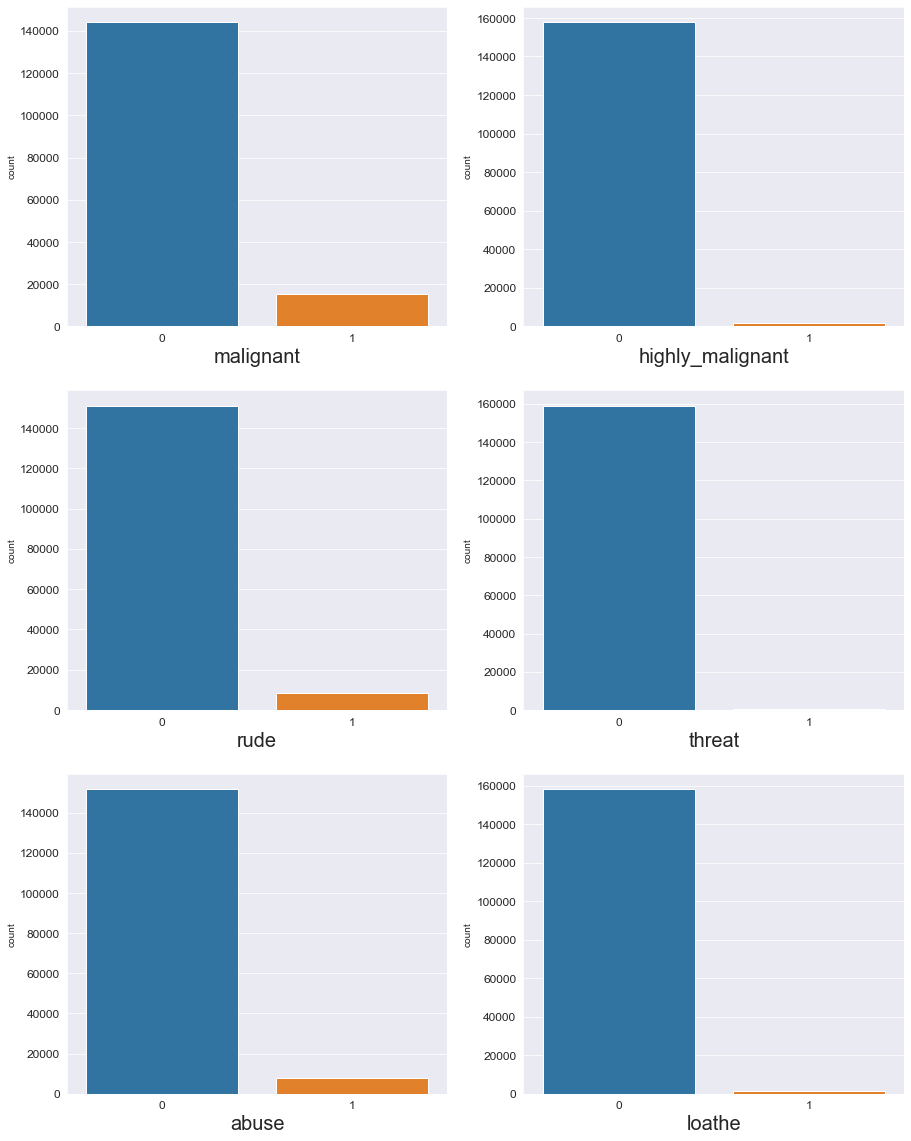

In [75]:
# Plotting countplot for all the features
categories=train1.columns[1:]
plt.figure(figsize=(15,20),facecolor='white')
plotnumber=1
for col in comment_cat:
    if plotnumber<=6:
        ax=plt.subplot(3,2,plotnumber)
        sns.countplot(train1[col])
        plt.xlabel(col,fontsize=20)
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)
    plotnumber += 1
plt.show()

In [76]:
#Checking the percentage distibution of type of comments
positive_comments = train1[(train1['malignant']!=1) & (train1['highly_malignant']!=1) & (train1['rude']!=1) & 
                            (train1['threat']!=1) & (train1['abuse']!=1) & (train1['loathe']!=1)]
percent=len(positive_comments)/len(train1)*100
print('Percentage of positive comments = ',percent)
print('Percentage of negative comments = ', (100-percent))

Percentage of positive comments =  89.83211235124176
Percentage of negative comments =  10.167887648758239


In [77]:
neg_count = train1.iloc[:,1:].sum().rename(' ')

In [78]:
neg_count.sort_values(ascending=False)

malignant           15294
rude                 8449
abuse                7877
highly_malignant     1595
loathe               1405
threat                478
Name:  , dtype: int64

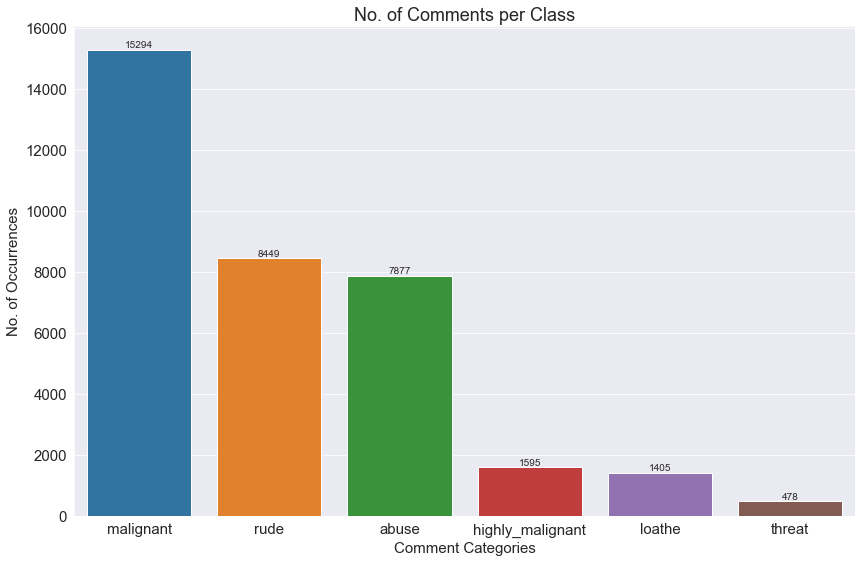

In [79]:
# Plot a chart with the following size
plt.figure(figsize=(14,9))

# Plot a bar chart using the index (category values) and the count of each category.
ax = sns.barplot(neg_count.index, neg_count.values, order=neg_count.sort_values(ascending=False).index)

plt.title("No. of Comments per Class", fontsize=18)
plt.ylabel('No. of Occurrences', fontsize=15)
plt.xlabel('Comment Categories', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
rects = ax.patches
labels = neg_count.sort_values(ascending=False).values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

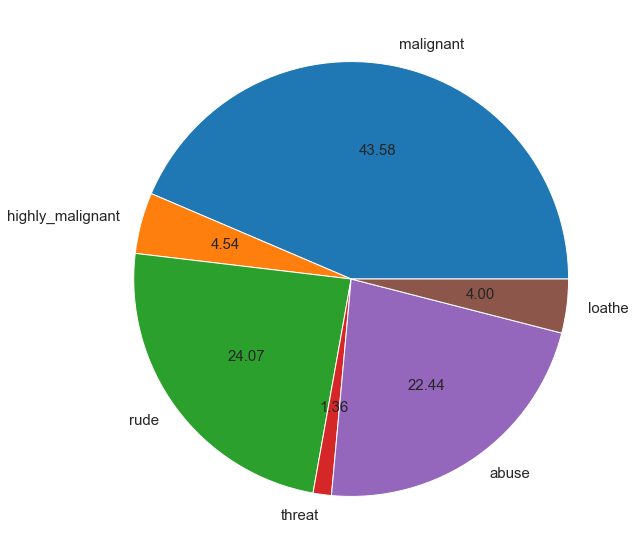

In [80]:
#Visualizing the label distribution of comments using pie chart
neg_count.plot.pie(autopct='%2.2f', figsize = (10,10),fontsize=15);

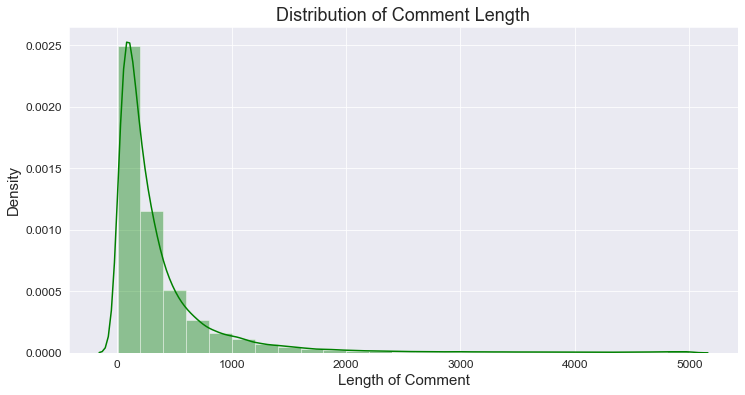

In [81]:
#Distribution of comments length
plt.figure(figsize=(12,6))
comment_len = train1['comment_text'].str.len()
sns.distplot(comment_len, bins=25, color = 'green')

plt.title("Distribution of Comment Length", fontsize=18)
plt.ylabel('Density', fontsize=15)
plt.xlabel('Length of Comment', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## checking Correlation between target variables

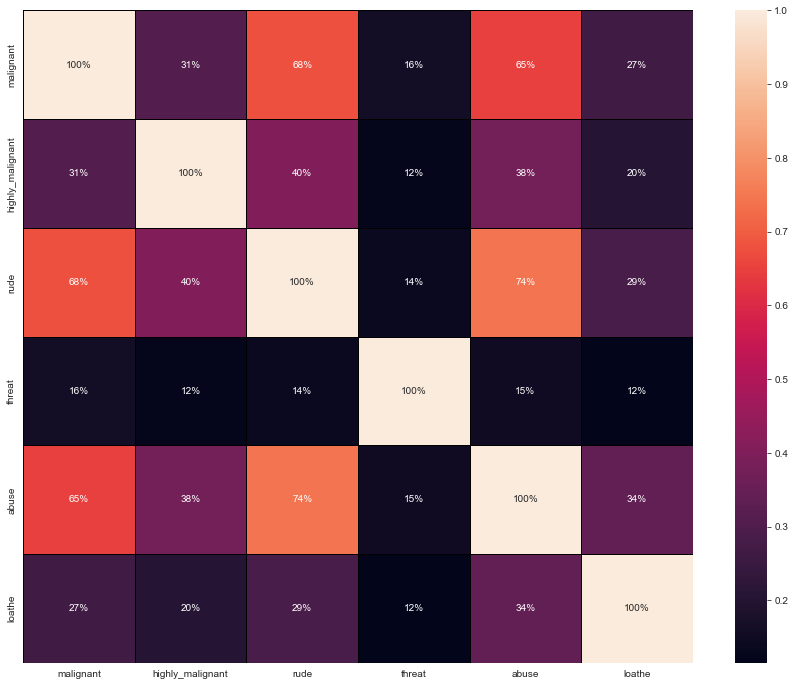

In [82]:
# Plotting heatmap for visualizing the correlation
plt.figure(figsize=(15, 12))
corr = train1.corr() # corr() function provides the correlation value of each column
sns.heatmap(corr, linewidth=0.5, linecolor='black', fmt='.0%', annot=True,)
plt.show()

## importing Natural language Toolkit library

In [83]:
import re
import nltk
# nltk.download('stopwords')
# nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

### Applying Stopwords & lemmatization on the training & tes set provided

In [84]:
lemmatizer = WordNetLemmatizer()

In [85]:
# apply stopwords lemmatize on train dataset
corpus = []
for sentence in train1['comment_text']:
    review = re.sub('[^a-zA-Z]', ' ', sentence)
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)

In [86]:
# apply stopwords lemmatize on test dataset
corpus_test = []
for sentence in test1['comment_text']:
    review = re.sub('[^a-zA-Z]', ' ', sentence)
    review = review.lower()
    review = review.split()
    review = [lemmatizer.lemmatize(word) for word in review if not word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus_test.append(review)

### Saving the cleaned data

In [88]:
train2 = pd.concat([train1, pd.DataFrame(corpus, columns = ['text_lemmatize'])], axis=1)
train2.to_csv('cleaned.csv',index=False)

In [89]:
test2 = pd.concat([test1, pd.DataFrame(corpus_test, columns = ['text_lemmatize'])], axis=1)
test2.to_csv('cleaned_test.csv',index=False)

In [90]:
train2

,comment_text,malignant,highly_malignant,rude,threat,abuse,loathe,text_lemmatize
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explanation edits made username hardcore metal...
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seemingly stuck th...
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man really trying edit war guy constantly ...
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggestion improvement wondered sect...
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chance remember page
...,...,...,...,...,...,...,...,...
159566,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,second time asking view completely contradicts...
159567,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,ashamed horrible thing put talk page
159568,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,spitzer umm there actual article prostitution ...
159569,And it looks like it was actually you who put ...,0,0,0,0,0,0,look like actually put speedy first version de...


## checking for missing after applying lemmatization

In [91]:
train2.isnull().sum()

comment_text          0
malignant             0
highly_malignant      0
rude                  0
threat                0
abuse                 0
loathe                0
text_lemmatize      111
dtype: int64

In [92]:
test2.isnull().sum()

comment_text        0
text_lemmatize    972
dtype: int64

### Dropping missing

In [93]:
train2.dropna(inplace=True)
test2.dropna(inplace=True)

## Using Word cloud to visualize most occuring words in the lemmatized comments

In [33]:
from wordcloud import WordCloud

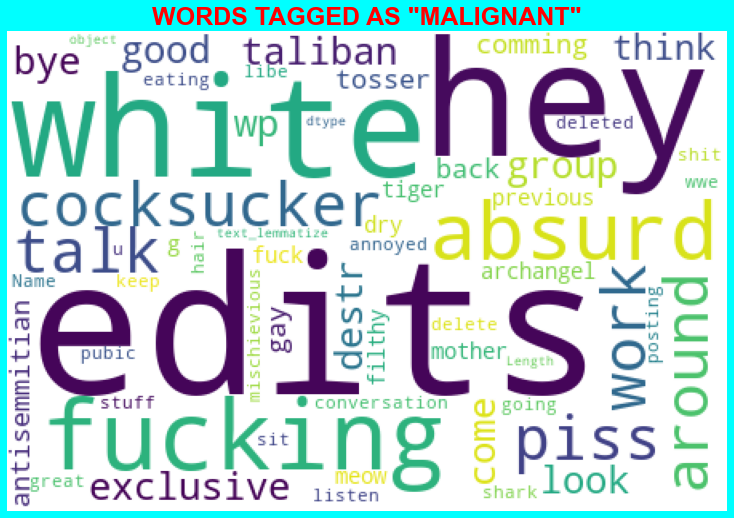

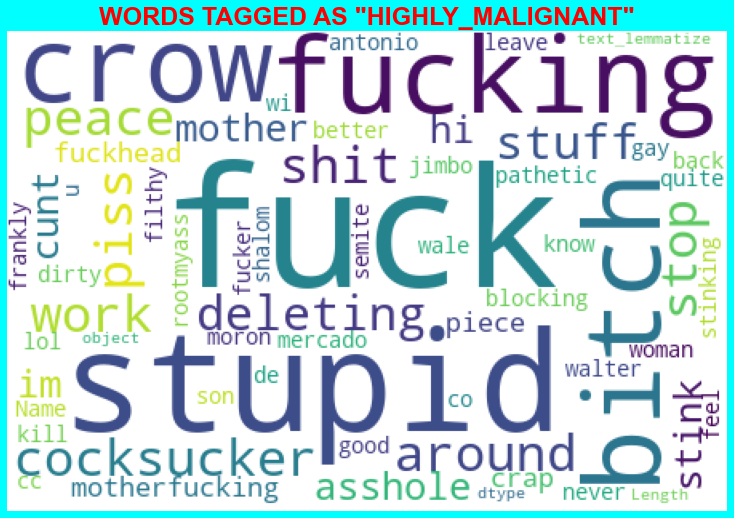

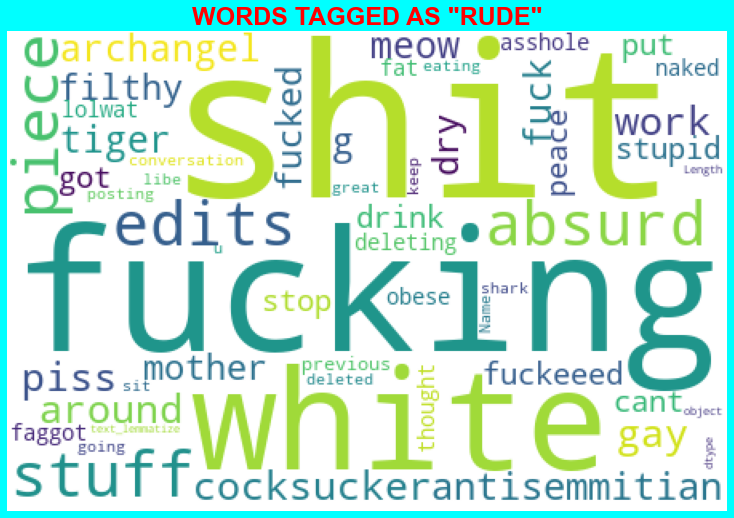

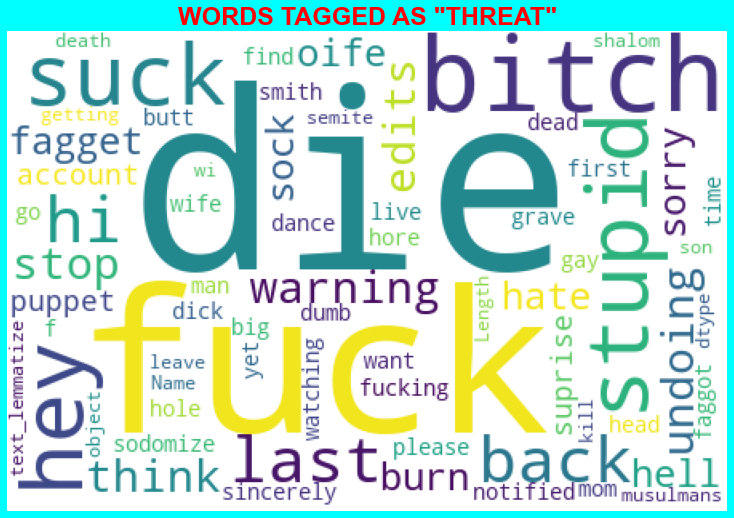

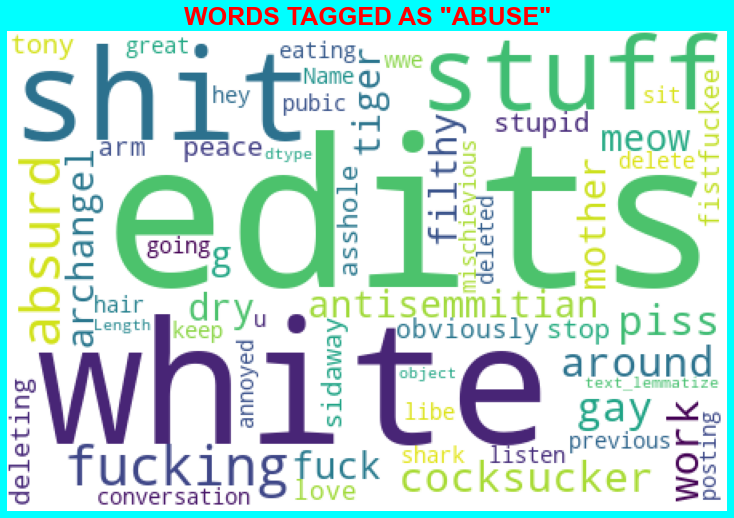

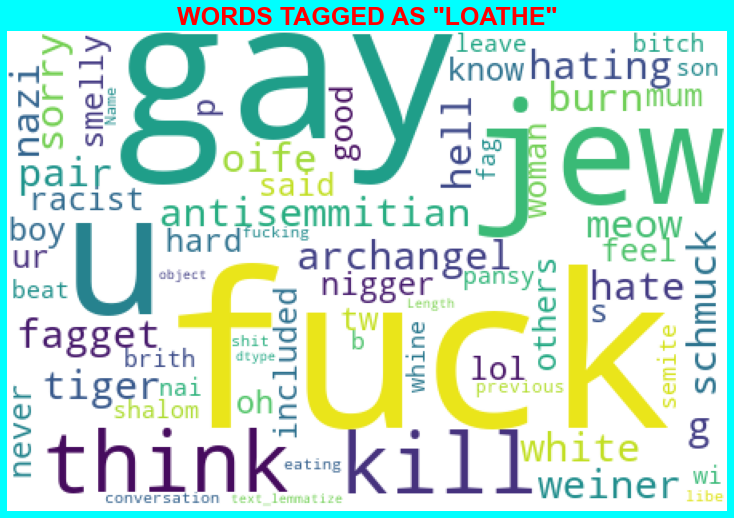

In [34]:
# Plotting for malignant
for cat in comment_cat:
    temp1=train2[(train2[cat]==1)]
    wordcloud=WordCloud(height=300,width=450,max_words=300,background_color="white").generate(str(temp1['text_lemmatize']))
    plt.figure(figsize=(10,10),facecolor='cyan')
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.tight_layout(pad=0)
    
    plt.title(label='WORDS TAGGED AS "'+ cat.upper()+'"', fontdict={'fontsize':25,'fontweight':'bold', 'color':'red'})
    plt.show()
    print(' ')
    print('='*96)
    print(' ')

## Using TFIDF to vectorize the lemmatized text

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
# Converting the features into number vectors
vec = TfidfVectorizer(max_features = 2000, stop_words='english')

In [37]:
from scipy.sparse import csr_matrix

In [38]:
# Let's Separate the input and output variables represented by X and y respectively in train data and convert them
X = vec.fit_transform(train2['text_lemmatize']).toarray()
cols = train2.columns[1:-1]
Y = csr_matrix(train2[cols]).toarray()

In [39]:
X.shape

(159460, 2000)

In [40]:
Y.shape

(159460, 6)

In [94]:
fin_test = vec.fit_transform(test2['text_lemmatize']).toarray()

# Classification model Selection

In [44]:
f1_scores = []
precision_scores = []
hamming_losses = []
accuracies_train = []
accuracies_test = []

lgr = LogisticRegression(solver='lbfgs')
mnb = MultinomialNB()
xgb = XGBClassifier()
lsvc = LinearSVC(max_iter = 3000)
lgbm = LGBMClassifier()
knc = KNeighborsClassifier()
rfc = RandomForestClassifier()
sgdc = SGDClassifier()



models = [lgr,mnb,xgb,lsvc,lgbm,knc,rfc,sgdc]
models_name = ['Logistic Regression','Multinomial Naive Bayes',
               'XGB Classifier','Linear SVC','LightGBM Classifier',
               'KNeighbors Classifier','Random Forest Classifier','StochasticGB Classifier']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 42)


dummy_count = 0
for model in models:
    to_fit = OneVsRestClassifier(model)
    to_fit.fit(x_train,y_train)
    pred_train = to_fit.predict(x_train)
    pred_test = to_fit.predict(x_test)
    print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
    print(' ')
    print(' ')
    print('for '+ models_name[dummy_count] + ' model..')
    print(' ')
    print(f"Accuracy score for Train : {accuracy_score(y_train,pred_train) * 100:.2f}%")
    accuracies_train.append(round(accuracy_score(y_train,pred_train)* 100,2))
    
    print(f"Accuracy score for Test : {accuracy_score(y_test,pred_test) * 100:.2f}%")
    accuracies_test.append(round(accuracy_score(y_test,pred_test)* 100,2))
    
    print(f"F1 score for Test : {f1_score(y_test,pred_test,average='micro') * 100:.2f}%")
    f1_scores.append(round(f1_score(y_test,pred_test,average='micro')* 100,2)) 
    
    print(f"Precision for Test : {precision_score(y_test,pred_test,average='micro') * 100:.2f}%")
    precision_scores.append(round(precision_score(y_test,pred_test,average='micro')* 100,2))
    
    print(f"Hamming Loss : {hamming_loss(y_test,pred_test) * 100:.2f}%")
    hamming_losses.append(round(hamming_loss(y_test,pred_test)* 100,2))
    
    print(' ')
    print(' ')
    print('Confusion Matrix: ')
    print(' ')
    print(multilabel_confusion_matrix(y_test, pred_test))
    print(' ')
    print(' ')
    print('Test Classification report: ')
    print(' ')
    print(classification_report(y_test, pred_test))
    dummy_count+=1

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
for Logistic Regression model..
 
Accuracy score for Train : 92.12%
Accuracy score for Test : 91.76%
F1 score for Test : 66.65%
Precision for Test : 86.02%
Hamming Loss : 1.99%
 
 
Confusion Matrix: 
 
[[[35791   247]
  [ 1609  2218]]

 [[39424    52]
  [  306    83]]

 [[37593   149]
  [  776  1347]]

 [[39723    15]
  [  113    14]]

 [[37663   270]
  [  922  1010]]

 [[39470    41]
  [  265    89]]]
 
 
Test Classification report: 
 
              precision    recall  f1-score   support

           0       0.90      0.58      0.71      3827
           1       0.61      0.21      0.32       389
           2       0.90      0.63      0.74      2123
           3       0.48      0.11      0.18       127
           4       0.79      0.52      0.63      1932
           5       0.68      0.25      0.37       354

   micro avg       0.86      0.54      0.67      8752
   macro avg       0.73      0.39      0.49      8

In [45]:
### dataframe to make list of all the ML algorithms & their evaluation metrics
table = pd.DataFrame(list(zip(models_name, accuracies_train, accuracies_test, precision_scores, f1_scores, hamming_losses)),
                              columns =['models_name', 'accuracies_train', 'accuracies_test', 'precision_scores', 'f1_scores', 'hamming_losses'])


### display dataframe.
table.sort_values(by=['accuracies_test', 'hamming_losses', 'precision_scores' ])

,models_name,accuracies_train,accuracies_test,precision_scores,f1_scores,hamming_losses
5,KNeighbors Classifier,91.27,89.19,67.42,48.65,2.94
1,Multinomial Naive Bayes,91.55,91.26,87.56,60.47,2.21
6,Random Forest Classifier,99.10,91.29,80.18,67.88,2.04
7,StochasticGB Classifier,91.67,91.47,88.73,62.85,2.10
4,LightGBM Classifier,93.10,91.60,81.86,68.20,1.99
2,XGB Classifier,93.54,91.65,83.84,67.12,2.01
3,Linear SVC,92.28,91.74,84.71,67.89,1.96
0,Logistic Regression,92.12,91.76,86.02,66.65,1.99


### Observation
We will select Logistic Regressor model as it has,

- Maximum ACCURACY with high Precision value.
- minimum hamming loss.


# Hyper paramter tuning using GridSearchCV

In [46]:
param = {'estimator__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
         'estimator__max_iter' : [100, 200, 300, 400],
         'estimator__multi_class' : ['ovr', 'auto']}
          
lgr_ovr = OneVsRestClassifier(lgr)
lgr_grid = GridSearchCV(lgr_ovr, param, cv=5,verbose = 2)
x_train,x_test,y_train,y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
lgr_grid.fit(x_train,y_train)
lgr_grid.best_params_

Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV] END estimator__max_iter=100, estimator__multi_class=ovr, estimator__penalty=l1; total time=   6.7s
[CV] END estimator__max_iter=100, estimator__multi_class=ovr, estimator__penalty=l1; total time=   0.9s
[CV] END estimator__max_iter=100, estimator__multi_class=ovr, estimator__penalty=l1; total time=   0.8s
[CV] END estimator__max_iter=100, estimator__multi_class=ovr, estimator__penalty=l1; total time=   0.6s
[CV] END estimator__max_iter=100, estimator__multi_class=ovr, estimator__penalty=l1; total time=   0.6s
[CV] END estimator__max_iter=100, estimator__multi_class=ovr, estimator__penalty=l2; total time= 1.2min
[CV] END estimator__max_iter=100, estimator__multi_class=ovr, estimator__penalty=l2; total time= 1.3min
[CV] END estimator__max_iter=100, estimator__multi_class=ovr, estimator__penalty=l2; total time= 1.3min
[CV] END estimator__max_iter=100, estimator__multi_class=ovr, estimator__penalty=l2; total time= 1.5min
[C

[CV] END estimator__max_iter=200, estimator__multi_class=auto, estimator__penalty=none; total time= 4.0min
[CV] END estimator__max_iter=200, estimator__multi_class=auto, estimator__penalty=none; total time= 4.0min
[CV] END estimator__max_iter=200, estimator__multi_class=auto, estimator__penalty=none; total time= 4.1min
[CV] END estimator__max_iter=200, estimator__multi_class=auto, estimator__penalty=none; total time= 4.1min
[CV] END estimator__max_iter=300, estimator__multi_class=ovr, estimator__penalty=l1; total time=   5.6s
[CV] END estimator__max_iter=300, estimator__multi_class=ovr, estimator__penalty=l1; total time=   3.1s
[CV] END estimator__max_iter=300, estimator__multi_class=ovr, estimator__penalty=l1; total time=   1.0s
[CV] END estimator__max_iter=300, estimator__multi_class=ovr, estimator__penalty=l1; total time=   0.6s
[CV] END estimator__max_iter=300, estimator__multi_class=ovr, estimator__penalty=l1; total time=   0.6s
[CV] END estimator__max_iter=300, estimator__multi_c

[CV] END estimator__max_iter=400, estimator__multi_class=auto, estimator__penalty=elasticnet; total time=   0.6s
[CV] END estimator__max_iter=400, estimator__multi_class=auto, estimator__penalty=elasticnet; total time=   0.5s
[CV] END estimator__max_iter=400, estimator__multi_class=auto, estimator__penalty=none; total time= 7.2min
[CV] END estimator__max_iter=400, estimator__multi_class=auto, estimator__penalty=none; total time= 7.5min
[CV] END estimator__max_iter=400, estimator__multi_class=auto, estimator__penalty=none; total time= 7.5min
[CV] END estimator__max_iter=400, estimator__multi_class=auto, estimator__penalty=none; total time= 8.5min
[CV] END estimator__max_iter=400, estimator__multi_class=auto, estimator__penalty=none; total time= 9.2min


{'estimator__max_iter': 100,
 'estimator__multi_class': 'ovr',
 'estimator__penalty': 'l2'}

In [47]:
lgr_grid.best_score_

0.9182658137882018

In [49]:
lgr_tune = LogisticRegression(solver='lbfgs', max_iter= 100,penalty= 'l2',multi_class= 'ovr')

In [51]:
lgr_tune_final = OneVsRestClassifier(lgr_tune)
lgr_tune_final.fit(x_train,y_train)
pred_train = lgr_tune_final.predict(x_train)
pred_test = lgr_tune_final.predict(x_test)
print('::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::')
print(' ')
print(' ')
print('for '+ models_name[0] + ' model..')
print(' ')
print(f"Accuracy score for Train : {accuracy_score(y_train,pred_train) * 100:.2f}%")
# accuracies_train.append(round(accuracy_score(y_train,pred_train)* 100,2))

print(f"Accuracy score for Test : {accuracy_score(y_test,pred_test) * 100:.2f}%")
# accuracies_test.append(round(accuracy_score(y_test,pred_test)* 100,2))

print(f"F1 score for Test : {f1_score(y_test,pred_test,average='micro') * 100:.2f}%")
# f1_scores.append(round(f1_score(y_test,pred_test,average='micro')* 100,2)) 

print(f"Precision for Test : {precision_score(y_test,pred_test,average='micro') * 100:.2f}%")
# precision_scores.append(round(precision_score(y_test,pred_test,average='micro')* 100,2))

print(f"Hamming Loss : {hamming_loss(y_test,pred_test) * 100:.2f}%")
# hamming_losses.append(round(hamming_loss(y_test,pred_test)* 100,2))

print(' ')
print(' ')
print('Confusion Matrix: ')
print(' ')
print(multilabel_confusion_matrix(y_test, pred_test))
print(' ')
print(' ')
print('Test Classification report: ')
print(' ')
print(classification_report(y_test, pred_test))

::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::::
 
 
for Logistic Regression model..
 
Accuracy score for Train : 92.12%
Accuracy score for Test : 91.76%
F1 score for Test : 66.65%
Precision for Test : 86.02%
Hamming Loss : 1.99%
 
 
Confusion Matrix: 
 
[[[35791   247]
  [ 1609  2218]]

 [[39424    52]
  [  306    83]]

 [[37593   149]
  [  776  1347]]

 [[39723    15]
  [  113    14]]

 [[37663   270]
  [  922  1010]]

 [[39470    41]
  [  265    89]]]
 
 
Test Classification report: 
 
              precision    recall  f1-score   support

           0       0.90      0.58      0.71      3827
           1       0.61      0.21      0.32       389
           2       0.90      0.63      0.74      2123
           3       0.48      0.11      0.18       127
           4       0.79      0.52      0.63      1932
           5       0.68      0.25      0.37       354

   micro avg       0.86      0.54      0.67      8752
   macro avg       0.73      0.39      0.49      8

# Model Saving & Predicting on the test set provided

In [53]:
import pickle

In [54]:
filename='Malignant_commnet_classifier.pkl'
pickle.dump(lgr_tune_final,open(filename,'wb'))

In [55]:
model =pickle.load(open('Malignant_commnet_classifier.pkl','rb'))
pred =model.predict(fin_test)

In [57]:
test_predictions_cleaned = pd.concat([test2['text_lemmatize'],
                                      pd.DataFrame(pred, columns= ['malignant','highly_malignant','rude',
                                                                   'threat','abuse','loathe'])], axis=1)

In [59]:
test_predictions_cleaned.to_csv('test_predictions.csv',index=False)

In [61]:
test_predicted = pd.read_csv('test_predictions.csv')
test_predicted

,text_lemmatize,malignant,highly_malignant,rude,threat,abuse,loathe
0,yo bitch ja rule succesful ever whats hating s...,1,1,1,0,1,0
1,rfc title fine imo,0,0,0,0,0,0
2,source zawe ashton lapland,0,0,0,0,0,0
3,look back source information updated correct f...,0,0,0,0,0,0
4,anonymously edit article,0,0,0,0,0,0
...,...,...,...,...,...,...,...
153159,totally agree stuff nothing long crap,1,0,1,0,0,0
153160,throw field home plate get faster throwing cut...,0,0,0,0,0,0
153161,okinotorishima category see change agree corre...,0,0,0,0,0,0
153162,one founding nation eu germany law return quit...,0,0,0,0,0,0
